In [1]:
from compressor import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class xyDataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, x, y):
        self.x = x#torch.tensor(x).to(torch.float)
        self.y = y#torch.tensor(y).to(torch.float)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.x[idx], self.y[idx]]
        return sample

In [3]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
sim_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
#sim_accept_reject_PATH = '../pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
#sim_fPrel_PATH = '../pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")
#sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
#sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental hadrons shape:', exp_hadrons.shape)
print('Simulated hadrons shape:', sim_hadrons.shape)
#print('Simulated z shape:', sim_accept_reject.shape)
#print('Simulated fPrel shape:', sim_fPrel.shape)

# Extract pz (in-channel = 1)
exp_pz = exp_hadrons[:,:,3]
sim_pz = sim_hadrons[:,:,3]

# Convert to torch tensors
exp_pz = torch.tensor(exp_pz).to(torch.float)
sim_pz = torch.tensor(sim_pz).to(torch.float)

# Sort in pz
exp_pz, _ = torch.sort(exp_pz, dim=1)
sim_pz, _ = torch.sort(sim_pz, dim=1)

# Reverse the order of the exp_pz
exp_pz = torch.flip(exp_pz, [1])
sim_pz = torch.flip(sim_pz, [1])

# Combine the exp and sim hadron datasets
hadrons = torch.cat((exp_pz, sim_pz), 0).unsqueeze(1)
#print('Combined hadrons shape:', hadrons.shape)
print('Combined hadrons:', hadrons)

"""
# For more than one in-channel - i.e. (px, py, pz, E, m)

# Combine the exp and sim hadron datasets
#hadrons = np.concatenate((exp_hadrons, sim_hadrons), axis=0)
#print('Combines hadrons shape:', hadrons.shape)
# Convert to torch tensor
#hadrons = torch.tensor(hadrons).to(torch.float)

# Reshape for the compressor
#hadrons = hadrons.transpose(1, 2)
#print('Reshaped hadrons shape:', hadrons.shape)
"""

# Generate labels
labels_exp = np.full((exp_hadrons.shape[0], 2), [0., 1.])
labels_sim = np.full((sim_hadrons.shape[0], 2), [1., 0.])

# Combine the labels in a consistent way with the hadrons
labels = np.concatenate((labels_exp, labels_sim), axis=0)
# Convert to torch tensor
labels = torch.tensor(labels).to(torch.float)
print('Combined labels shape:', labels.shape)

# Constuct the dataset and initialize the PyTorch dataLoader
trainset = xyDataset(labels, hadrons)
batch_size = 5000
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
print('Number of batches:', len(trainloader))

Experimental hadrons shape: (100000, 75, 5)
Simulated hadrons shape: (100000, 75, 5)
Combined hadrons: tensor([[[16.8237, 16.5214, 14.8597,  ...,  0.0000,  0.0000,  0.0000]],

        [[24.3806, 18.4189, 16.1389,  ...,  0.0000,  0.0000,  0.0000]],

        [[15.2658, 13.5052, 12.8365,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[30.6371, 17.4666, 13.5157,  ...,  0.0000,  0.0000,  0.0000]],

        [[38.7202, 20.5032, 14.5690,  ...,  0.0000,  0.0000,  0.0000]],

        [[15.0854, 13.7852, 11.3777,  ...,  0.0000,  0.0000,  0.0000]]])
Combined labels shape: torch.Size([200000, 2])
Number of batches: 40


In [10]:
# Define the hyperparameters
input_dim = exp_hadrons.shape[1]
output_dim = input_dim
latent_dim = 2
conditional = True
num_labels = 2

# Initialize the model
model = Compressor(input_dim = input_dim, output_dim = output_dim, latent_dim = latent_dim, conditional = conditional, num_labels = num_labels)

In [11]:
print('model:', model)

model: Compressor(
  (embed_class): Linear(in_features=2, out_features=75, bias=True)
  (embed_data): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
  (features_encode): Sequential(
    (0): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (10): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): Le

In [12]:
# Test out the encoder
print(trainloader.dataset[0][1].unsqueeze(0))
print(trainloader.dataset[0][0].unsqueeze(0))
enc = model.encode(trainloader.dataset[0][1].unsqueeze(0), trainloader.dataset[0][0].unsqueeze(0))
print('Encoded shape:', enc.shape)
print('Encoded:', enc)
dec = model.decode(enc, trainloader.dataset[0][0].unsqueeze(0))
print('Decoded shape:', dec.shape)
print('Decoded:', dec)

tensor([[[16.8237, 16.5214, 14.8597, 12.8871, 11.3744,  2.4894,  2.4407,
           1.9850,  1.8907,  1.3179,  1.0674,  1.0235,  0.7792,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
tensor([[0., 1.]])
Encoded shape: torch.Size([1, 2])
Encoded: tensor([[-0.0367, -0.0789]], grad_fn=<AddmmBackward0>)
Decoded shape: torch.Size([1, 1, 75])
Decoded: tensor([[[-0.0183, -0.0202, -0.0188, -0.0250, -0

In [14]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 10)

# Initialize the training loop
num_epochs = 25

# Training loop
for epoch in tqdm(range(num_epochs), ncols = 100):
    for i, data in enumerate(trainloader):
        labels, hadrons = data
        hadrons_hat, z = model(hadrons, labels)
        
        recons_loss_l1 = nn.functional.l1_loss(hadrons_hat, hadrons)
        recons_loss_l2 = nn.functional.mse_loss(hadrons_hat, hadrons)

        bce_loss = nn.functional.binary_cross_entropy_with_logits(z, labels)

        loss = recons_loss_l1 + recons_loss_l2 + bce_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update the learning rate scheduler
        #scheduler.step(loss)
    print('-----------------------------------------')
    print('Epoch:', epoch, '\n', 'Loss:', loss.item(), '\n', 'Learning rate:', optimizer.param_groups[0]['lr'], '\n', 'Reconstruction Loss L1:', recons_loss_l1.item(), '\n', 'Reconstruction Loss L2:', recons_loss_l2.item(), '\n', 'BCE Loss:', bce_loss.item())
    print('-----------------------------------------')


  4%|██▌                                                             | 1/25 [00:20<08:22, 20.95s/it]

-----------------------------------------
Epoch: 0 
 Loss: 3.954291343688965 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.614935040473938 
 Reconstruction Loss L2: 2.657318353652954 
 BCE Loss: 0.6820377707481384
-----------------------------------------


  8%|█████                                                           | 2/25 [00:47<09:23, 24.50s/it]

-----------------------------------------
Epoch: 1 
 Loss: 2.5739517211914062 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.42599761486053467 
 Reconstruction Loss L2: 1.821557641029358 
 BCE Loss: 0.32639655470848083
-----------------------------------------


 12%|███████▋                                                        | 3/25 [01:10<08:41, 23.72s/it]

-----------------------------------------
Epoch: 2 
 Loss: 2.036926746368408 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.3899261951446533 
 Reconstruction Loss L2: 1.5763943195343018 
 BCE Loss: 0.07060633599758148
-----------------------------------------


 16%|██████████▏                                                     | 4/25 [01:32<08:03, 23.01s/it]

-----------------------------------------
Epoch: 3 
 Loss: 1.6370618343353271 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.35467129945755005 
 Reconstruction Loss L2: 1.2517856359481812 
 BCE Loss: 0.030604803934693336
-----------------------------------------


 20%|████████████▊                                                   | 5/25 [01:55<07:35, 22.79s/it]

-----------------------------------------
Epoch: 4 
 Loss: 1.5113811492919922 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.33101168274879456 
 Reconstruction Loss L2: 1.1613099575042725 
 BCE Loss: 0.019059501588344574
-----------------------------------------


 24%|███████████████▎                                                | 6/25 [02:15<06:57, 21.96s/it]

-----------------------------------------
Epoch: 5 
 Loss: 1.1968605518341064 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.34654244780540466 
 Reconstruction Loss L2: 0.7962894439697266 
 BCE Loss: 0.054028674960136414
-----------------------------------------


 28%|█████████████████▉                                              | 7/25 [02:39<06:49, 22.73s/it]

-----------------------------------------
Epoch: 6 
 Loss: 0.9586946368217468 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.27677682042121887 
 Reconstruction Loss L2: 0.6722704172134399 
 BCE Loss: 0.00964741688221693
-----------------------------------------


 32%|████████████████████▍                                           | 8/25 [03:06<06:45, 23.87s/it]

-----------------------------------------
Epoch: 7 
 Loss: 0.8625861406326294 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.24817311763763428 
 Reconstruction Loss L2: 0.6047055125236511 
 BCE Loss: 0.009707539342343807
-----------------------------------------


 36%|███████████████████████                                         | 9/25 [03:31<06:31, 24.45s/it]

-----------------------------------------
Epoch: 8 
 Loss: 0.8335694074630737 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.25321611762046814 
 Reconstruction Loss L2: 0.5692776441574097 
 BCE Loss: 0.011075600050389767
-----------------------------------------


 40%|█████████████████████████▏                                     | 10/25 [03:54<06:00, 24.03s/it]

-----------------------------------------
Epoch: 9 
 Loss: 0.8643959760665894 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.24273425340652466 
 Reconstruction Loss L2: 0.6117834448814392 
 BCE Loss: 0.009878273122012615
-----------------------------------------


 44%|███████████████████████████▋                                   | 11/25 [04:18<05:35, 23.99s/it]

-----------------------------------------
Epoch: 10 
 Loss: 0.7622168064117432 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.24211083352565765 
 Reconstruction Loss L2: 0.508645236492157 
 BCE Loss: 0.011460751295089722
-----------------------------------------


 48%|██████████████████████████████▏                                | 12/25 [04:38<04:53, 22.56s/it]

-----------------------------------------
Epoch: 11 
 Loss: 0.7101542949676514 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.22184059023857117 
 Reconstruction Loss L2: 0.47645899653434753 
 BCE Loss: 0.011854720301926136
-----------------------------------------


 52%|████████████████████████████████▊                              | 13/25 [04:58<04:21, 21.79s/it]

-----------------------------------------
Epoch: 12 
 Loss: 0.6770780682563782 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.2286646068096161 
 Reconstruction Loss L2: 0.43773216009140015 
 BCE Loss: 0.0106813358142972
-----------------------------------------


 56%|███████████████████████████████████▎                           | 14/25 [05:18<03:53, 21.27s/it]

-----------------------------------------
Epoch: 13 
 Loss: 0.591942548751831 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.2033885419368744 
 Reconstruction Loss L2: 0.38249725103378296 
 BCE Loss: 0.006056758109480143
-----------------------------------------


 60%|█████████████████████████████████████▊                         | 15/25 [05:42<03:40, 22.07s/it]

-----------------------------------------
Epoch: 14 
 Loss: 0.5365226864814758 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.19615556299686432 
 Reconstruction Loss L2: 0.33548906445503235 
 BCE Loss: 0.004878041800111532
-----------------------------------------


 64%|████████████████████████████████████████▎                      | 16/25 [06:00<03:09, 21.02s/it]

-----------------------------------------
Epoch: 15 
 Loss: 0.5245802998542786 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.1968267858028412 
 Reconstruction Loss L2: 0.3233267366886139 
 BCE Loss: 0.004426755476742983
-----------------------------------------


 68%|██████████████████████████████████████████▊                    | 17/25 [06:52<04:02, 30.33s/it]

-----------------------------------------
Epoch: 16 
 Loss: 0.506738007068634 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.19237197935581207 
 Reconstruction Loss L2: 0.3097061216831207 
 BCE Loss: 0.004659871105104685
-----------------------------------------


 72%|█████████████████████████████████████████████▎                 | 18/25 [07:16<03:17, 28.26s/it]

-----------------------------------------
Epoch: 17 
 Loss: 0.5137486457824707 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.1969517320394516 
 Reconstruction Loss L2: 0.30842557549476624 
 BCE Loss: 0.008371351286768913
-----------------------------------------


 76%|███████████████████████████████████████████████▉               | 19/25 [07:39<02:40, 26.76s/it]

-----------------------------------------
Epoch: 18 
 Loss: 0.4846108853816986 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.18728560209274292 
 Reconstruction Loss L2: 0.29342642426490784 
 BCE Loss: 0.003898851340636611
-----------------------------------------


 80%|██████████████████████████████████████████████████▍            | 20/25 [08:04<02:11, 26.21s/it]

-----------------------------------------
Epoch: 19 
 Loss: 0.4922621250152588 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.19326308369636536 
 Reconstruction Loss L2: 0.2954482138156891 
 BCE Loss: 0.0035508223809301853
-----------------------------------------


 84%|████████████████████████████████████████████████████▉          | 21/25 [08:26<01:40, 25.10s/it]

-----------------------------------------
Epoch: 20 
 Loss: 0.4996592104434967 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.19803428649902344 
 Reconstruction Loss L2: 0.2986869812011719 
 BCE Loss: 0.0029379543848335743
-----------------------------------------


 88%|███████████████████████████████████████████████████████▍       | 22/25 [08:48<01:12, 24.13s/it]

-----------------------------------------
Epoch: 21 
 Loss: 0.47989991307258606 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.1982889175415039 
 Reconstruction Loss L2: 0.27798962593078613 
 BCE Loss: 0.003621357027441263
-----------------------------------------


 92%|█████████████████████████████████████████████████████████▉     | 23/25 [09:10<00:47, 23.53s/it]

-----------------------------------------
Epoch: 22 
 Loss: 0.46810680627822876 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.18972179293632507 
 Reconstruction Loss L2: 0.27558761835098267 
 BCE Loss: 0.0027974038384854794
-----------------------------------------


 96%|████████████████████████████████████████████████████████████▍  | 24/25 [09:29<00:22, 22.16s/it]

-----------------------------------------
Epoch: 23 
 Loss: 0.48322558403015137 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.18936043977737427 
 Reconstruction Loss L2: 0.29056471586227417 
 BCE Loss: 0.0033004265278577805
-----------------------------------------


100%|███████████████████████████████████████████████████████████████| 25/25 [09:54<00:00, 23.76s/it]

-----------------------------------------
Epoch: 24 
 Loss: 0.47689831256866455 
 Learning rate: 0.01 
 Reconstruction Loss L1: 0.19905506074428558 
 Reconstruction Loss L2: 0.27509406208992004 
 BCE Loss: 0.002749193226918578
-----------------------------------------


In [15]:
# Encode the hadrons
exp_z = model.encode(exp_pz.unsqueeze(1), torch.tensor(labels_exp).to(torch.float)).detach().numpy()
sim_z = model.encode(sim_pz.unsqueeze(1), torch.tensor(labels_sim).to(torch.float)).detach().numpy()
# Check the decoder
exp_hadrons_hat = model.decode(torch.tensor(exp_z), torch.tensor(labels_exp).to(torch.float)).detach().numpy()
sim_hadrons_hat = model.decode(torch.tensor(sim_z), torch.tensor(labels_sim).to(torch.float)).detach().numpy()

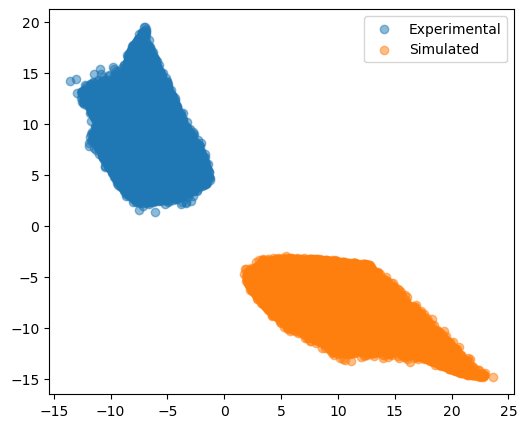

In [16]:
# Plot the latent space
plt.figure(figsize=(6,5))
plt.scatter(exp_z[:, 0], exp_z[:, 1], label = 'Experimental', alpha = 0.5)
plt.scatter(sim_z[:, 0], sim_z[:, 1], label = 'Simulated', alpha = 0.5)
plt.legend()
plt.show()

(array([   0.,    6.,   27.,   90.,  222.,  482.,  826., 1186., 1688.,
        2116., 2433., 3032., 3355., 3347., 3474., 3922., 4145., 4313.,
        4418., 4336., 4055., 4175., 3888., 3594., 3398., 3344., 3366.,
        3158., 2878., 2632., 2456., 2245., 2089., 1955., 1785., 1530.,
        1501., 1323., 1134., 1084., 1048.,  843.,  795.,  614.,  529.,
         437.,  304.,  222.,  104.,   65.]),
 array([ 8.90320015,  9.72448444, 10.54576778, 11.36705208, 12.18833637,
        13.00961971, 13.83090401, 14.6521883 , 15.47347164, 16.29475594,
        17.11603928, 17.93732452, 18.75860786, 19.5798912 , 20.40117645,
        21.22245979, 22.04374313, 22.86502838, 23.68631172, 24.50759506,
        25.32888031, 26.15016365, 26.97144699, 27.79273224, 28.61401558,
        29.43529892, 30.25658417, 31.07786751, 31.89915276, 32.7204361 ,
        33.54172134, 34.36300278, 35.18428802, 36.00557327, 36.82685471,
        37.64813995, 38.4694252 , 39.29070663, 40.11199188, 40.93327713,
        41.75455

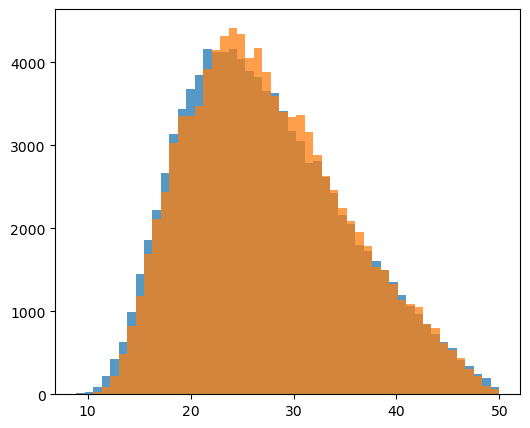

In [38]:
# Plot the hadrons
plt.figure(figsize=(6,5))
_, bins, _ = plt.hist(sim_pz[:,0], 50, alpha = 0.75, label = 'Experimental')
plt.hist(sim_hadrons_hat[:,0,0], bins, alpha = 0.75, label = 'Experimental hat')
plt.legend()
plt.tight_layout()


(array([   0.,    0.,    0.,   15.,  159.,  422.,  622.,  967., 1202.,
        1613., 2186., 2386., 2756., 3052., 3393., 3644., 3902., 3863.,
        4011., 3908., 3718., 3864., 3568., 3531., 3348., 3338., 3219.,
        3037., 3005., 2795., 2588., 2484., 2329., 2137., 2079., 1875.,
        1728., 1579., 1543., 1401., 1237., 1154., 1030.,  935.,  826.,
         711.,  701.,  579.,  509.,  400.]),
 array([ 9.04337025,  9.86157322, 10.67977524, 11.49797821, 12.31618023,
        13.1343832 , 13.95258522, 14.77078819, 15.58899117, 16.40719414,
        17.2253952 , 18.04359818, 18.86180115, 19.68000412, 20.49820709,
        21.31640816, 22.13461113, 22.9528141 , 23.77101707, 24.58922005,
        25.40742111, 26.22562408, 27.04382706, 27.86203003, 28.68023109,
        29.49843407, 30.31663704, 31.13484001, 31.95304298, 32.77124405,
        33.58944702, 34.40764999, 35.22585297, 36.04405594, 36.86225891,
        37.68046188, 38.49866104, 39.31686401, 40.13506699, 40.95326996,
        41.77147

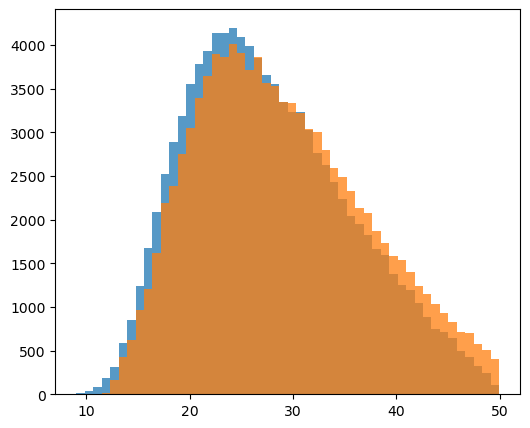

In [27]:
# Plot the hadrons
plt.figure(figsize=(6,5))
_, bins, _ = plt.hist(exp_pz[:,0], 50, alpha = 0.75, label = 'Experimental')
plt.hist(exp_hadrons_hat[:,0,0], bins, alpha = 0.75, label = 'Experimental hat')

(array([  11.,   44.,   98.,  250.,  437.,  684., 1044., 1495., 1905.,
        2261., 2711., 3183., 3400., 3729., 3842., 4155., 4141., 4129.,
        4138., 3990., 3863., 3818., 3619., 3622., 3355., 3154., 3035.,
        2767., 2804., 2573., 2404., 2149., 2043., 1784., 1718., 1578.,
        1504., 1324., 1207., 1071.,  948.,  839.,  718.,  620.,  553.,
         413.,  344.,  246.,  190.,   86.]),
 array([ 9.04337025,  9.86157322, 10.67977524, 11.49797821, 12.31618023,
        13.1343832 , 13.95258522, 14.77078819, 15.58899117, 16.40719414,
        17.2253952 , 18.04359818, 18.86180115, 19.68000412, 20.49820709,
        21.31640816, 22.13461113, 22.9528141 , 23.77101707, 24.58922005,
        25.40742111, 26.22562408, 27.04382706, 27.86203003, 28.68023109,
        29.49843407, 30.31663704, 31.13484001, 31.95304298, 32.77124405,
        33.58944702, 34.40764999, 35.22585297, 36.04405594, 36.86225891,
        37.68046188, 38.49866104, 39.31686401, 40.13506699, 40.95326996,
        41.77147

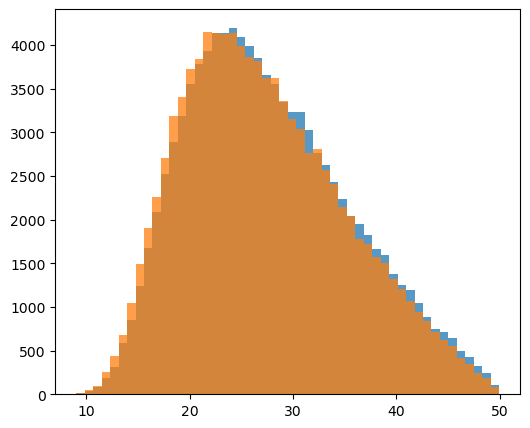

In [39]:
# Plot the hadrons
plt.figure(figsize=(6,5))
_, bins, _ = plt.hist(exp_pz[:,0], 50, alpha = 0.75, label = 'Experimental')
plt.hist(sim_pz[:,0], bins, alpha = 0.75, label = 'Experimental hat')

In [40]:
# Save the model
torch.save(model.state_dict(), 'compressor.pt')